In [2]:
import torch
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch import tensor
import torch.distributions as dist

# This helper is exposed for testing.
def _Dirichlet_backward(x, concentration, grad_output):
    total = concentration.sum(-1, True).expand_as(concentration)
    grad = torch._dirichlet_grad(x, concentration, total)
    return grad * (grad_output - (x * grad_output).sum(-1, True))


class _Dirichlet(Function):
    @staticmethod
    def forward(ctx, concentration):
        x = torch._sample_dirichlet(concentration)
        ctx.save_for_backward(x, concentration)
        return x

    @staticmethod
    @once_differentiable
    def backward(ctx, grad_output):
        x, concentration = ctx.saved_tensors
        return _Dirichlet_backward(x, concentration, grad_output)


class Dirichlet2(ExponentialFamily):
    r"""
    Creates a Dirichlet distribution parameterized by concentration :attr:`concentration`.
    Example::
        >>> m = Dirichlet(torch.tensor([0.5, 0.5]))
        >>> m.sample()  # Dirichlet distributed with concentrarion concentration
        tensor([ 0.1046,  0.8954])
    Args:
        concentration (Tensor): concentration parameter of the distribution
            (often referred to as alpha)
    """
    arg_constraints = {'concentration': constraints.positive}
    support = constraints.simplex
    has_rsample = True

    def __init__(self, concentration, validate_args=None):
        if concentration.dim() < 1:
            raise ValueError("`concentration` parameter must be at least one-dimensional.")
        self.concentration = concentration
        batch_shape, event_shape = concentration.shape[:-1], concentration.shape[-1:]
        super(Dirichlet2, self).__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(Dirichlet, _instance)
        batch_shape = torch.Size(batch_shape)
        new.concentration = self.concentration.expand(batch_shape + self.event_shape)
        super(Dirichlet2, new).__init__(batch_shape, self.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def rsample(self, sample_shape=()):
        shape = self._extended_shape(sample_shape)
        concentration = self.concentration.expand(shape)
        return _Dirichlet.apply(concentration)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
            
        return ((torch.log(value) * (self.concentration - 1.0)).sum(-1) +
                torch.lgamma(self.concentration.sum(-1)) -
                torch.lgamma(self.concentration).sum(-1))

    @property
    def mean(self):
        return self.concentration / self.concentration.sum(-1, True)

    @property
    def variance(self):
        con0 = self.concentration.sum(-1, True)
        return self.concentration * (con0 - self.concentration) / (con0.pow(2) * (con0 + 1))

    def entropy(self):
        k = self.concentration.size(-1)
        a0 = self.concentration.sum(-1)
        return (torch.lgamma(self.concentration).sum(-1) - torch.lgamma(a0) -
                (k - a0) * torch.digamma(a0) -
                ((self.concentration - 1.0) * torch.digamma(self.concentration)).sum(-1))

    @property
    def _natural_params(self):
        return (self.concentration, )

    def _log_normalizer(self, x):
        return x.lgamma().sum(-1) - torch.lgamma(x.sum(-1))

In [3]:
# ZIGDM REGRESSION MODEL
# https://www.dropbox.com/s/xbcjaazpqisbie1/Screenshot%202020-04-07%2018.14.33.png?dl=0



In [4]:
Dirichlet2?

Init signature: Dirichlet2(concentration, validate_args=None)
Docstring:     
Creates a Dirichlet distribution parameterized by concentration :attr:`concentration`.
Example::
    >>> m = Dirichlet(torch.tensor([0.5, 0.5]))
    >>> m.sample()  # Dirichlet distributed with concentrarion concentration
    tensor([ 0.1046,  0.8954])
Args:
    concentration (Tensor): concentration parameter of the distribution
        (often referred to as alpha)
Type:           type
Subclasses:     


In [5]:
Dirichlet?

Object `Dirichlet` not found.


In [6]:
Dirichlet2(torch.tensor([.5,.5]))

Dirichlet2(concentration: torch.Size([2]))

In [7]:
a = tensor([[1],[2],[3],[4],[5]])

In [8]:
a.sum(-1)

tensor([1, 2, 3, 4, 5])

In [9]:
import numbers

import torch
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all

from pyro.distributions.torch import Beta, Binomial, Dirichlet, Gamma, Multinomial, Poisson
from pyro.distributions.torch_distribution import TorchDistribution

class DirichletMultinomial2(TorchDistribution):
    r"""
    Compound distribution comprising of a dirichlet-multinomial pair. The probability of
    classes (``probs`` for the :class:`~pyro.distributions.Multinomial` distribution)
    is unknown and randomly drawn from a :class:`~pyro.distributions.Dirichlet`
    distribution prior to a certain number of Categorical trials given by
    ``total_count``.
    :param float or torch.Tensor concentration: concentration parameter (alpha) for the
        Dirichlet distribution.
    :param int or torch.Tensor total_count: number of Categorical trials.
    """
    arg_constraints = {'concentration': constraints.positive, 'total_count': constraints.nonnegative_integer}
    support = Multinomial.support

    def __init__(self, concentration, total_count=1, validate_args=None):
        if isinstance(total_count, numbers.Number):
            total_count = concentration.new_tensor(total_count)
        total_count_1 = total_count.unsqueeze(-1)
        concentration, total_count = torch.broadcast_tensors(concentration, total_count_1)
        total_count = total_count_1.squeeze(-1)
        self._dirichlet = Dirichlet(concentration)
        self.total_count = total_count
        super(DirichletMultinomial2, self).__init__(
            self._dirichlet._batch_shape, self._dirichlet.event_shape, validate_args=validate_args)

    @property
    def concentration(self):
        return self._dirichlet.concentration

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(DirichletMultinomial, _instance)
        batch_shape = torch.Size(batch_shape)
        new._dirichlet = self._dirichlet.expand(batch_shape)
        new.total_count = self.total_count.expand(batch_shape)
        super(DirichletMultinomial2, new).__init__(
            new._dirichlet.batch_shape, new._dirichlet.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def sample(self, sample_shape=()):
        probs = self._dirichlet.sample(sample_shape)
        total_count = int(self.total_count.max())
        if not self.total_count.min() == total_count:
            raise NotImplementedError("Inhomogeneous total count not supported by `enumerate_support`.")
        return Multinomial(total_count, probs).sample()

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.total_count
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1)
        return (_log_factorial(n) + torch.lgamma(alpha_sum) - torch.lgamma(n + alpha_sum) +
                (torch.lgamma(value + alpha) - _log_factorial(value) - torch.lgamma(alpha)).sum(-1))

    @property
    def mean(self):
        return self._dirichlet.mean * self.total_count.unsqueeze(-1)

    @property
    def variance(self):
        n = self.total_count.unsqueeze(-1)
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1, keepdim=True)
        alpha_ratio = alpha / alpha_sum
        return n * alpha_ratio * (1 - alpha_ratio) * (n + alpha_sum) / (1 + alpha_sum)

In [10]:
def simpleGD(alphas, betas):
    Z = Beta(alphas, betas)
    
    

In [11]:
Beta?

Init signature: Beta(concentration1, concentration0, validate_args=None)
Docstring:     
Wraps :class:`torch.distributions.beta.Beta` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/miniconda3/lib/python3.7/site-packages/pyro/distributions/torch.py
Type:           ABCMeta
Subclasses:     


In [12]:
import pyro
import torch
from torch import tensor
from pyro.distributions import Dirichlet, Beta, DirichletMultinomial, Multinomial

In [13]:
def beta():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-13-de911f38635e>, line 2)

In [14]:
def log_prob(prevZsProduct):
    Z[j] = Beta(a[j], b[j])
    P[j] = Z[j] * prevZsProduct

In [15]:
torch.mvlgamma?

Docstring:
mvlgamma(input, p) -> Tensor

Computes the `multivariate log-gamma function
<https://en.wikipedia.org/wiki/Multivariate_gamma_function>`_) with dimension
:math:`p` element-wise, given by

.. math::
    \log(\Gamma_{p}(a)) = C + \displaystyle \sum_{i=1}^{p} \log\left(\Gamma\left(a - \frac{i - 1}{2}\right)\right)

where :math:`C = \log(\pi) \times \frac{p (p - 1)}{4}` and :math:`\Gamma(\cdot)` is the Gamma function.

All elements must be greater than :math:`\frac{p - 1}{2}`, otherwise an error would be thrown.

Args:
    input (Tensor): the tensor to compute the multivariate log-gamma function
    p (int): the number of dimensions

Example::

    >>> a = torch.empty(2, 3).uniform_(1, 2)
    >>> a
    tensor([[1.6835, 1.8474, 1.1929],
            [1.0475, 1.7162, 1.4180]])
    >>> torch.mvlgamma(a, 2)
    tensor([[0.3928, 0.4007, 0.7586],
            [1.0311, 0.3901, 0.5049]])
Type:      builtin_function_or_method


In [16]:
a = torch.empty(2, 3).uniform_(1, 2)

In [17]:
a

tensor([[1.3271, 1.2820, 1.7448],
        [1.3808, 1.0909, 1.1400]])

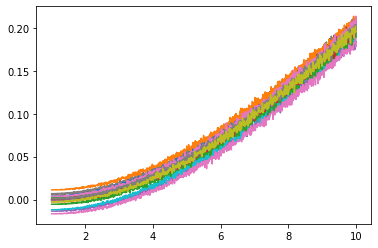

In [584]:
for conc in range(1, 20):
    maxRR1 = 20
    maxRR2 = 20
    res = []
    rr1 = dist.Gamma(concentration=conc,rate=conc/float(maxRR1)).sample([20_000])
    rr2 = dist.Gamma(concentration=conc,rate=conc/float(maxRR2)).sample([20_000])
    
    trueMax = max(maxRR1, maxRR2)
    sharedRRmin = 1 #int(trueMax * .33)
    for i in range(sharedRRmin, trueMax * 50):
        y = i / 100.
        rr3a = dist.Gamma(concentration=conc,rate=conc/y).sample([20_000])
        res.append(np.corrcoef(rr1+rr3a, rr2+rr3a)[0,1])
    plt.plot(np.linspace(sharedRRmin,trueMax/2,trueMax  * 50 - sharedRRmin), res)

In [583]:
# Should be linear from rr3's rrMean being .4
# Expect ~ .06-.08 increase in correlation for every ~.1 increase in proportion compared to min(rr1, rr2) between .33 and 1
conc=10
maxRR = 300
rr1 = dist.Gamma(concentration=conc,rate=conc/float(maxRR)).sample([20_000])
rr2 = dist.Gamma(concentration=conc,rate=conc/float(maxRR)).sample([20_000])

rr3 = dist.Gamma(concentration=conc,rate=conc/(maxRR*.1)).sample([20_000])
# expect ~.02
print(np.corrcoef(rr1+rr3, rr2+rr3)[0,1])

rr3 = dist.Gamma(concentration=conc,rate=conc/(maxRR*.2)).sample([20_000])
# expect ~.04
print(np.corrcoef(rr1+rr3, rr2+rr3)[0,1])

rr3 = dist.Gamma(concentration=conc,rate=conc/(maxRR*.33)).sample([20_000])
# expect ~.1
print(np.corrcoef(rr1+rr3, rr2+rr3)[0,1])

rr3 = dist.Gamma(concentration=conc,rate=conc/(maxRR *.43)).sample([20_000])
# expect ~.16
print(np.corrcoef(rr1+rr3, rr2+rr3)[0,1])

rr3 = dist.Gamma(concentration=conc,rate=conc/(maxRR)).sample([20_000])
# expect ~.5
print(np.corrcoef(rr1+rr3, rr2+rr3)[0,1])

0.014117604592876656
0.043043902184681376
0.10067543062582124
0.15766839973977764
0.5012264915688008


In [320]:
np.linspace(0,20, 200)

array([ 0.        ,  0.10050251,  0.20100503,  0.30150754,  0.40201005,
        0.50251256,  0.60301508,  0.70351759,  0.8040201 ,  0.90452261,
        1.00502513,  1.10552764,  1.20603015,  1.30653266,  1.40703518,
        1.50753769,  1.6080402 ,  1.70854271,  1.80904523,  1.90954774,
        2.01005025,  2.11055276,  2.21105528,  2.31155779,  2.4120603 ,
        2.51256281,  2.61306533,  2.71356784,  2.81407035,  2.91457286,
        3.01507538,  3.11557789,  3.2160804 ,  3.31658291,  3.41708543,
        3.51758794,  3.61809045,  3.71859296,  3.81909548,  3.91959799,
        4.0201005 ,  4.12060302,  4.22110553,  4.32160804,  4.42211055,
        4.52261307,  4.62311558,  4.72361809,  4.8241206 ,  4.92462312,
        5.02512563,  5.12562814,  5.22613065,  5.32663317,  5.42713568,
        5.52763819,  5.6281407 ,  5.72864322,  5.82914573,  5.92964824,
        6.03015075,  6.13065327,  6.23115578,  6.33165829,  6.4321608 ,
        6.53266332,  6.63316583,  6.73366834,  6.83417085,  6.93

In [294]:
(rr1 + rr3).mean()

tensor(20.0234)

In [90]:
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

af = 1e-4

In [91]:
# bp1 = dist.Binomial(probs=pVgivenD(rr1, af)).sample([20_000, ])
# bp2 = dist.Binomial(probs=pVgivenD(rr1, af)).sample([20_000, ])
# bp3 = dist.Binomial(probs=pVgivenD(rr1, af)).sample([20_000, ])

pcor1 = pVgivenD(rr1 + rr3, af)
print(pcor1)
pcor2 = pVgivenD(rr2 + rr3, af)
print(pcor2)


tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020])
tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020])


In [97]:
pcor1.min()

tensor(0.0019)

In [119]:
bpc1 = dist.Binomial(probs=pcor1, total_count=10000).sample()
bpc2 = dist.Binomial(probs=pcor1, total_count=10000).sample()



In [118]:
bpc1.size()

torch.Size([20000])

In [106]:
dist.Binomial?

Init signature: dist.Binomial(total_count=1, probs=None, logits=None, validate_args=None)
Docstring:     
Creates a Binomial distribution parameterized by :attr:`total_count` and
either :attr:`probs` or :attr:`logits` (but not both). :attr:`total_count` must be
broadcastable with :attr:`probs`/:attr:`logits`.

Example::

    >>> m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
    >>> x = m.sample()
    tensor([   0.,   22.,   71.,  100.])

    >>> m = Binomial(torch.tensor([[5.], [10.]]), torch.tensor([0.5, 0.8]))
    >>> x = m.sample()
    tensor([[ 4.,  5.],
            [ 7.,  6.]])

Args:
    total_count (int or Tensor): number of Bernoulli trials
    probs (Tensor): Event probabilities
    logits (Tensor): Event log-odds
File:           ~/miniconda3/lib/python3.7/site-packages/torch/distributions/binomial.py
Type:           type
Subclasses:     Binomial


In [107]:
bpc1.mean(0)

tensor(1.9855)

In [99]:
bpc2.mean()

tensor(2.0097)

In [100]:
bpc2.std()

tensor(1.4252)

In [127]:
bpc1 - bpc1.mean()

tensor([ 5.0133,  5.0133, -6.9867,  ...,  6.0133, -4.9867,  8.0133])

In [131]:
10000*pcor1*(1-pcor1)

tensor([19.8548, 19.9251, 19.8790,  ..., 19.7856, 20.1643, 19.9768])

In [128]:
((bpc1 - bpc1.mean()) * (bpc2-bpc2.mean())).sum(0) / (bpc1.std()*bpc2.std())

tensor(15.4453)

In [124]:
np.corrcoef(bpc1, bpc2)

array([[1.00000000e+00, 7.72310673e-04],
       [7.72310673e-04, 1.00000000e+00]])

In [58]:
np.corrcoef?

Signature: np.corrcoef(x, y=None, rowvar=True, bias=<no value>, ddof=<no value>)
Docstring:
Return Pearson product-moment correlation coefficients.

Please refer to the documentation for `cov` for more detail.  The
relationship between the correlation coefficient matrix, `R`, and the
covariance matrix, `C`, is

.. math:: R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }

The values of `R` are between -1 and 1, inclusive.

Parameters
----------
x : array_like
    A 1-D or 2-D array containing multiple variables and observations.
    Each row of `x` represents a variable, and each column a single
    observation of all those variables. Also see `rowvar` below.
y : array_like, optional
    An additional set of variables and observations. `y` has the same
    shape as `x`.
rowvar : bool, optional
    If `rowvar` is True (default), then each row represents a
    variable, with observations in the columns. Otherwise, the relationship
    is transposed: each column represents a variable, 

In [40]:
bp1 = dist.Binomial(probs=pVgivenD(rr1, af), total_count=1e4).sample()
bp2 = dist.Binomial(probs=pVgivenD(rr2, af), total_count=1e4).sample()
bp3 = dist.Binomial(probs=pVgivenD(rr3, af), total_count=1e4).sample()

bpcor1 = bp1 + bp3
bpcor2 = bp2 + bp3

np.corrcoef(bpcor1, bpcor2)

array([[1.        , 0.67002874],
       [0.67002874, 1.        ]])

array([[1.        , 0.67176795],
       [0.67176795, 1.        ]])

In [ ]:
rr1 + rr3

In [ ]:
rr1

In [ ]:
rr3

In [ ]:
rr2

In [ ]:
rr3

In [ ]:
rr2+rr3

In [ ]:
np.corrcoef(pcor1, pcor2)

In [ ]:
dist.Binomial(probs=pcor1, total_count=1e5).sample()

In [ ]:
dist.Binomial(probs=pcor2, total_count=1e5).sample()

In [26]:
dist.Binomial?

Init signature: dist.Binomial(total_count=1, probs=None, logits=None, validate_args=None)
Docstring:     
Creates a Binomial distribution parameterized by :attr:`total_count` and
either :attr:`probs` or :attr:`logits` (but not both). :attr:`total_count` must be
broadcastable with :attr:`probs`/:attr:`logits`.

Example::

    >>> m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
    >>> x = m.sample()
    tensor([   0.,   22.,   71.,  100.])

    >>> m = Binomial(torch.tensor([[5.], [10.]]), torch.tensor([0.5, 0.8]))
    >>> x = m.sample()
    tensor([[ 4.,  5.],
            [ 7.,  6.]])

Args:
    total_count (int or Tensor): number of Bernoulli trials
    probs (Tensor): Event probabilities
    logits (Tensor): Event log-odds
File:           ~/miniconda3/lib/python3.7/site-packages/torch/distributions/binomial.py
Type:           type
Subclasses:     Binomial


In [132]:
from torch.distributions import MultivariateNormal

In [161]:
cov = tensor([[1.,.8],[.8,1.]])
mean = tensor([0.,0.])

In [134]:
MultivariateNormal?

Init signature:
MultivariateNormal(
    loc,
    covariance_matrix=None,
    precision_matrix=None,
    scale_tril=None,
    validate_args=None,
)
Docstring:     
Creates a multivariate normal (also called Gaussian) distribution
parameterized by a mean vector and a covariance matrix.

The multivariate normal distribution can be parameterized either
in terms of a positive definite covariance matrix :math:`\mathbf{\Sigma}`
or a positive definite precision matrix :math:`\mathbf{\Sigma}^{-1}`
or a lower-triangular matrix :math:`\mathbf{L}` with positive-valued
diagonal entries, such that
:math:`\mathbf{\Sigma} = \mathbf{L}\mathbf{L}^\top`. This triangular matrix
can be obtained via e.g. Cholesky decomposition of the covariance.

Example:

    >>> m = MultivariateNormal(torch.zeros(2), torch.eye(2))
    >>> m.sample()  # normally distributed with mean=`[0,0]` and covariance_matrix=`I`
    tensor([-0.2102, -0.5429])

Args:
    loc (Tensor): mean of the distribution
    covariance_matrix (Ten

In [174]:
t = MultivariateNormal(loc=tensor([0., 0.]), covariance_matrix=cov)

In [175]:
x = t.sample([10_000])

In [177]:
x

tensor([[ 0.2406, -0.0604],
        [-0.8690, -0.8349],
        [ 0.1792,  0.5476],
        ...,
        [ 0.6374,  1.9597],
        [ 1.0482,  0.8956],
        [ 1.4364,  1.1379]])

In [149]:
np.corrcoef(x[:, 0], x[:,1])

array([[1.        , 0.79901023],
       [0.79901023, 1.        ]])

In [152]:
t.cdf(tensor(.1))

NotImplementedError: 

In [ ]:
t.cdf()

In [153]:
import matplotlib.pyplot as plt

In [154]:
from scipy.stats import multivariate_normal

In [182]:
# cdf(x, mean=None, cov=1, allow_singular=False, maxpts=1000000*dim, abseps=1e-5, releps=1e-5)
y = multivariate_normal.cdf(x, mean=[0,0], cov=cov)

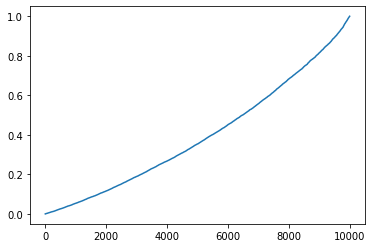

In [188]:
plt.plot(sorted(y))


In [178]:
x1 = np.linspace(0, 5, 10, endpoint=False)
print("x1", x1)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5); y

print("y", y)
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)

x1 [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]


ValueError: shapes (10000,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)

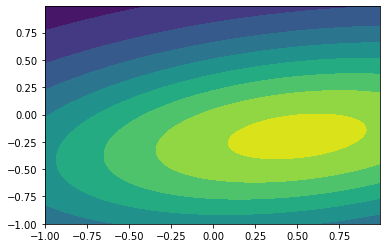

In [168]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

In [585]:
from torch.distributions import Categorical

In [603]:
Categorical(probs=tensor([.1, .3, .5, .8])).sample()

tensor(3)